In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['classic', 'ggplot'])

import numpy as np
import pandas as pd

# Define convolutional neural net
This net is based on one from the PyTorch tutorial (TODO name), adapted to
train on the MNIST database.

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        # input images are 1 channel, 28x28
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(4, 4), padding=4)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=(4, 4), padding=4)

        # fully-connected layers
        self.fc1 = nn.Linear(10 * 10 * 10, 120) # 2nd activations are 10x10x10
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Two convolution layers with ReLU and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        # flatten before fully-connected layers
        x = x.view(-1, self.num_flat_features(x))
        
        # fully-connected layers with ReLUs 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Final layer gives us class probabilities (no ReLU this time)
        x = self.fc3(x)
        return(x)

    def num_flat_features(self, x):
        '''
        Returns number of features in tensor
        '''
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return(num_features)

net = Net()

# Prepare MNIST dataset
I'll use batch size of 1, since I'm training on my local CPU.

In [3]:
# Run this command only once to download the dataset into the folder of your choice
#torchvision.datasets.MNIST(root='/Users/kat/coding/deepLearning/datasets', download=True);

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='/Users/kat/coding/deepLearning/datasets',
                           train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True,
                                          num_workers=1)

testset = torchvision.datasets.MNIST(root='/Users/kat/coding/deepLearning/datasets',
                           train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

Show an example training image:

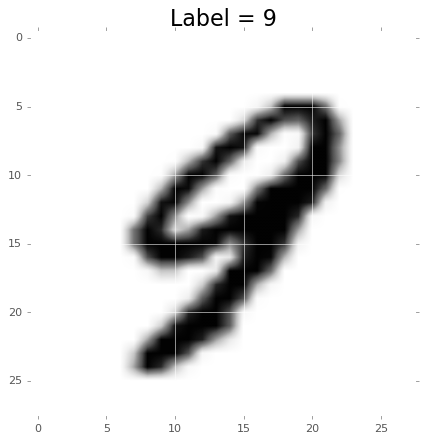

In [15]:
# Running this cell multiple times will show training examples in random order
dataiter = iter(trainloader)
image, label = dataiter.next()

plt.imshow(image.view(28,28).numpy(), cmap='Greys')
plt.title('Label = {}'.format(label.item()), fontsize=20);

# Train the convolutional network on MNIST training set

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [7]:
training_losses = []
for epoch in range(1):

    # There are 60,000 training images in MNIST. This takes a few minutes to
    # run on my MacBook Air.
    for i, data in enumerate(trainloader, 0):
        input, label = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(input)
        loss = criterion(output, label)
        training_losses.append(loss.item())
        loss.backward()
        optimizer.step()

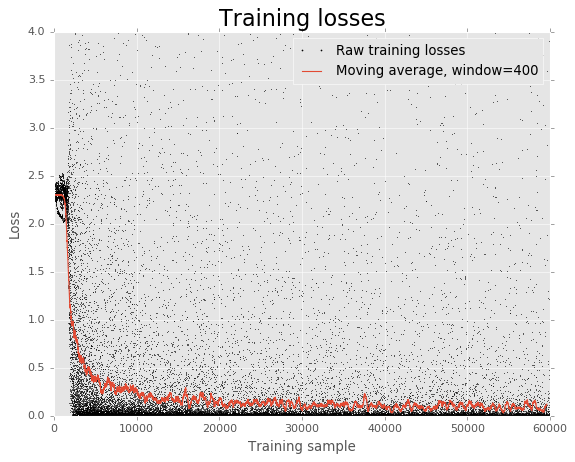

In [16]:
def moving_average(signal, window=400):
    weights = np.array([1.]*window)/window
    ma = np.convolve(signal, weights, mode = 'valid')
    return(ma)

plt.plot(training_losses, 'o', markersize=0.3, color='k')
# a hack to make the legend more legible
plt.plot(0,10,'o', markersize=1, color='k', label='Raw training losses')
plt.plot(moving_average(training_losses), label='Moving average, window=400');
plt.title('Training losses', fontsize=20);
plt.legend(loc='upper right')
plt.xlabel('Training sample');
plt.ylabel('Loss');
plt.ylim(0,4);

# Check accuracy on test set

First let's try running a single test example through the trained net. Running
the image through the net outputs the class predictions; the index of
the largest value is the predicted digit.

In [19]:
dataiter = iter(testloader)

Class predictions:
                0    1    2    3    4    5        6    7    8    9
predictions  11.2 -5.2 -1.2 -2.3 -3.3 -0.8 -5.2e-02  1.1  0.2  1.3


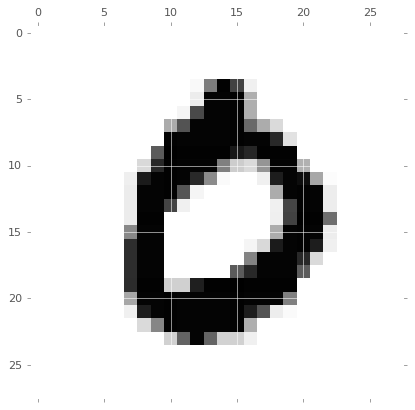

In [24]:
# Running this cell multiple times will show test examples in sequential order
image, label = dataiter.next()
output = net(image)

plt.matshow(image.view(28,28).numpy(), cmap='Greys');

print('Class predictions:')
output = net(image)
pd.set_option('precision', 1)
print(pd.DataFrame(output.detach().numpy(), index=['predictions']))

## Evaluate predictions on entire test dataset

In [11]:
confusion = np.zeros([10,10])
correct = 0
incorrect = 0

for i, data in enumerate(testloader):
    
    image, true_label = data
    output = net(image)
    
    # The predicted label is the index of the largest output
    predicted_label = np.argmax(output.detach().numpy())
    #true_label = true_label.item()

    confusion[true_label, predicted_label] += 1

    if true_label == predicted_label:
        correct += 1
    else:
        incorrect += 1

accuracy = correct / (correct + incorrect)
# Normalize confusion matrix
for i in range(10):
    s = sum(confusion[i,:])
    if s>0:
        confusion[i,:] = confusion[i,:]/s 

## Display confusion matrix
The off-diagonal values are close to zero; only a few of them are visibly
different from their neighbors.

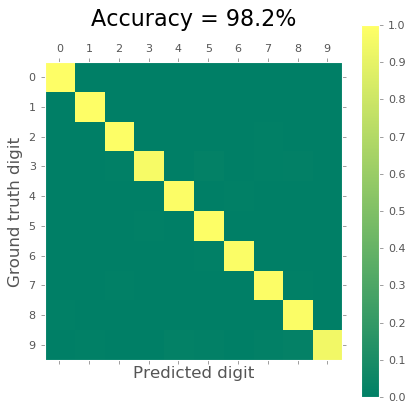

In [26]:
plt.matshow(confusion, cmap='summer', vmin=0., vmax=1.)
plt.colorbar()
plt.title('Accuracy = {:.3g}%'.format(100*accuracy),
          fontsize=20, pad = 20)
plt.ylabel('Ground truth digit', fontsize=15)
plt.xlabel('Predicted digit', fontsize=15)
plt.yticks(range(10))
plt.xticks(range(10))

plt.grid(color='k', which='minor', linewidth=0.5)
plt.grid(False, which='major')


For more detail, we can look at the raw numbers. (Rows are ground truth,
                                                  columns are predictions.)

In [13]:
df = pd.DataFrame(confusion)
pd.set_option('precision', 4)
print(df)

        0       1       2       3       4       5       6       7       8  \
0  0.9939  0.0000  0.0000  0.0000  0.0000  0.0010  0.0031  0.0010  0.0010   
1  0.0000  0.9938  0.0000  0.0000  0.0000  0.0018  0.0009  0.0000  0.0035   
2  0.0000  0.0010  0.9903  0.0000  0.0010  0.0000  0.0000  0.0058  0.0019   
3  0.0000  0.0000  0.0069  0.9663  0.0000  0.0129  0.0000  0.0059  0.0079   
4  0.0010  0.0020  0.0000  0.0000  0.9878  0.0000  0.0051  0.0010  0.0000   
5  0.0011  0.0000  0.0000  0.0045  0.0000  0.9910  0.0011  0.0000  0.0022   
6  0.0031  0.0021  0.0000  0.0010  0.0010  0.0052  0.9843  0.0000  0.0031   
7  0.0000  0.0039  0.0068  0.0000  0.0000  0.0000  0.0000  0.9844  0.0049   
8  0.0051  0.0000  0.0021  0.0010  0.0021  0.0031  0.0021  0.0021  0.9825   
9  0.0030  0.0050  0.0000  0.0000  0.0139  0.0079  0.0000  0.0089  0.0159   

        9  
0  0.0000  
1  0.0000  
2  0.0000  
3  0.0000  
4  0.0031  
5  0.0000  
6  0.0000  
7  0.0000  
8  0.0000  
9  0.9455  
